In [1]:
import pandas as pd
import numpy as np

patient = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Patient.csv")
lab = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Lab.csv")
lab_patient_merged = pd.merge(patient, lab, on="Patient_ID", how='inner')
lab_patient_merged['Site_ID'] = lab_patient_merged['Site_ID_x'].combine_first(lab_patient_merged['Site_ID_y'])
lab_patient_merged.drop(['Site_ID_x', 'Site_ID_y'], axis=1, inplace=True)

lab_patient_merged['DateCreated'] = pd.to_datetime(lab_patient_merged['DateCreated'])
lab_patient_merged['YearCreated'] = lab_patient_merged['DateCreated'].dt.year

mask = ~lab_patient_merged[['DateCreated', 'BirthYear']].isnull().any(axis=1)
lab_patient_merged['Age'] = np.nan
lab_patient_merged.loc[mask, 'Age'] = (
    (lab_patient_merged.loc[mask, 'DateCreated'] -
     pd.to_datetime(lab_patient_merged.loc[mask, 'BirthYear'].astype(str) + '-06-01'))
    .dt.days // 365
)

# Filter data for age >= 6
lab_patient_merged = lab_patient_merged[lab_patient_merged['Age'] >= 6]

C:\Users\suzielee\AppData\Local\Temp\ipykernel_15288\2404049435.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.read_csv("Z:\Ferretin Project\Ferritin Project\Lab.csv")
C:\Users\suzielee\AppData\Local\Temp\ipykernel_15288\2404049435.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  lab_patient_merged.loc[mask, 'Age'] = (


In [2]:
# Generating Hemoglobin Dataframe
Hgb = lab_patient_merged[lab_patient_merged['Code_calc'] == "718-7"]
Hgb_short = Hgb[['Patient_ID', 'Sex', 'Site_ID', 'TestResult_calc', 'YearCreated', 'Age']].copy()
Hgb_short['TestResult_calc'] = pd.to_numeric(Hgb_short['TestResult_calc'], errors='coerce')
print ("# of patients in Hgb dataframe:", Hgb_short['Patient_ID'].nunique())

# WHO anemia classifications. Note: sex distinction  15 and above.
conditions = [
    (Hgb_short['Age'] >= 6) & (Hgb_short['Age'] <= 11) & (Hgb_short['TestResult_calc'] < 11.5),
    (Hgb_short['Age'] >= 12) & (Hgb_short['Age'] <= 14) & (Hgb_short['TestResult_calc'] < 12),
    (Hgb_short['Age'] >= 15) & (Hgb_short['Sex'] == 'Female') & (Hgb_short['TestResult_calc'] < 12),
    (Hgb_short['Age'] >= 15) & (Hgb_short['Sex'] == 'Male') & (Hgb_short['TestResult_calc'] < 13)
]

# Defining the choices: if the condition is true, set anemia to 1 (Yes), otherwise 0 (No).
choices = [1, 1, 1, 1]
Hgb_short['anemia'] = np.select(conditions, choices, default=0)

# of patients in Hgb dataframe: 130098


In [3]:
# Sorting Hgb dataframe so that rows with anemia (1) come on top within each year
Hgb_short_sorted = Hgb_short.sort_values(by=['YearCreated', 'anemia'], ascending=[True, False])
# Drop duplicates to keep each unique patient represented: if anemic at least once that year, then count as anemic 
Hgb_short_unique = Hgb_short_sorted.drop_duplicates(subset=['YearCreated', 'Patient_ID'])

# Anemia Prevalence by year 
anemia_by_year = Hgb_short_unique.groupby('YearCreated')['anemia'].mean()
print(anemia_by_year)

YearCreated
2010    0.077696
2011    0.084162
2012    0.087382
2013    0.088740
2014    0.094073
2015    0.089174
2016    0.089363
2017    0.091688
2018    0.103796
2019    0.098474
2020    0.108610
2021    0.096339
2022    0.105166
Name: anemia, dtype: float64


In [4]:
anemia_by_year_by_sex = Hgb_short_unique.groupby(['YearCreated', 'Sex'])['anemia'].mean()
anemia_by_year_by_sex.to_csv('anemia_by_year_by_sex.csv')

In [5]:
# Generating Ferritin Dataframe
ferritin_lab = lab_patient_merged[lab_patient_merged['Code_calc'] == "2276-4"]
ferritin_lab_short = ferritin_lab[['Patient_ID', 'Sex', 'Site_ID', 'TestResult_calc', 'YearCreated', 'Age']].copy()
ferritin_lab_short['TestResult_calc'] = pd.to_numeric(ferritin_lab_short['TestResult_calc'], errors='coerce')

# Iron deficiency
ferritin_lab_short['iron_deficiency'] = ferritin_lab_short.groupby(['YearCreated', 'Patient_ID'])['TestResult_calc']\
    .transform(lambda x: (x < 15).any()).astype(int)

In [6]:
print("# of patients in overall data:", lab_patient_merged['Patient_ID'].nunique())
print("# of patients in hemoglobin dataframe:", Hgb_short['Patient_ID'].nunique())
print("# of patients in ferritin dataframe:", ferritin_lab_short['Patient_ID'].nunique())

# Find the overlap of individuals with both ferritin and hemoglobin data
overlap = ferritin_lab_short.merge(Hgb_short, on='Patient_ID', how='inner')
overlap_count = overlap['Patient_ID'].nunique()
percentage_overlap = (overlap_count / ferritin_lab_short['Patient_ID'].nunique()) * 100

print("% of patients in both ferritin and anemia dataframe:", percentage_overlap)
print("# of patients with both ferritin and hemoglobin dataframes:", overlap_count)


# of patients in overall data: 130521
# of patients in hemoglobin dataframe: 130098
# of patients in ferritin dataframe: 94264
% of patients in both ferritin and anemia dataframe: 99.73796995671731
# of patients with both ferritin and hemoglobin dataframes: 94017


In [7]:
# Sort the dataframe so that rows with iron deficiency (1) come on top within each year
ferritin_lab_short_sorted = ferritin_lab_short.sort_values(by=['YearCreated', 'iron_deficiency'], ascending=[True, False])
# Drop the duplicate rows to keep each unique patient only once
ferritin_lab_short_unique = ferritin_lab_short_sorted.drop_duplicates(subset=['YearCreated', 'Patient_ID'])
# Iron defiency prevalence by year
iron_deficiency_by_year = ferritin_lab_short_unique.groupby('YearCreated')['iron_deficiency'].mean()
print(iron_deficiency_by_year)

YearCreated
2010    0.078394
2011    0.081735
2012    0.077678
2013    0.066514
2014    0.071727
2015    0.066481
2016    0.066644
2017    0.066156
2018    0.070508
2019    0.070230
2020    0.061315
2021    0.058481
2022    0.044566
Name: iron_deficiency, dtype: float64


In [8]:
iron_deficiency_by_year = ferritin_lab_short_unique.groupby(['YearCreated', 'Sex'])['iron_deficiency'].mean()
print(iron_deficiency_by_year)
iron_deficiency_by_year.to_csv('iron_deficiency_by_year.csv')

YearCreated  Sex   
2010         Female    0.104643
             Male      0.017794
2011         Female    0.110383
             Male      0.017415
2012         Female    0.104153
             Male      0.021526
2013         Female    0.092573
             Male      0.015605
2014         Female    0.099011
             Male      0.018081
2015         Female    0.091112
             Male      0.016258
2016         Female    0.092908
             Male      0.016099
2017         Female    0.094792
             Male      0.012418
2018         Female    0.098649
             Male      0.017661
2019         Female    0.097768
             Male      0.019396
2020         Female    0.084253
             Male      0.016902
2021         Female    0.080343
             Male      0.015697
2022         Female    0.060898
             Male      0.012637
Name: iron_deficiency, dtype: float64


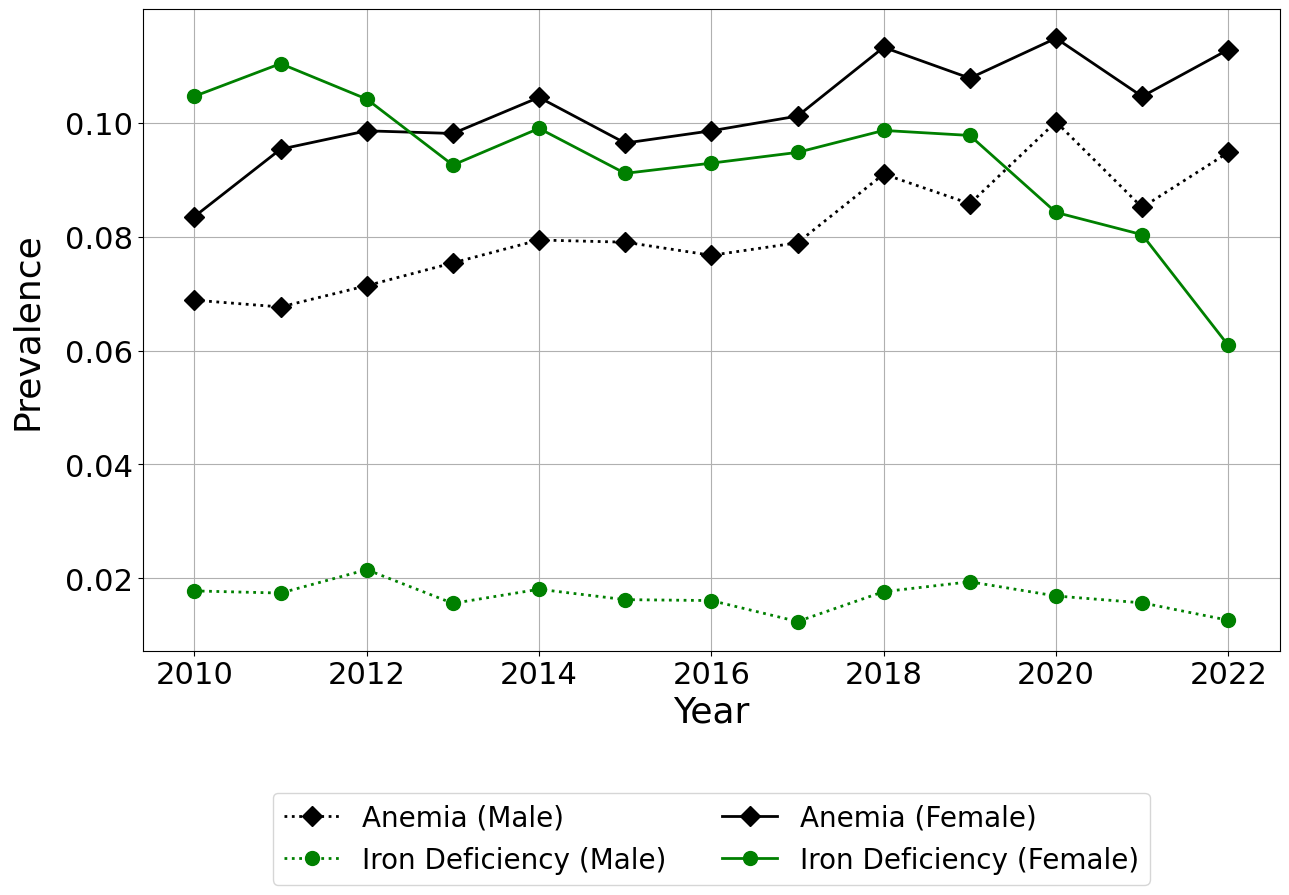

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

anemia_by_year_sex = Hgb_short_unique.groupby(['YearCreated', 'Sex'])['anemia'].mean()
iron_deficiency_by_year_sex = ferritin_lab_short_unique.groupby(['YearCreated', 'Sex'])['iron_deficiency'].mean()

# Figure: line plot. 
plt.figure(figsize=(13, 9))
markers = {'Male': {'anemia': 'D', 'iron_deficiency': 'o', 'linestyle': ':'},  
           'Female': {'anemia': 'D', 'iron_deficiency': 'o', 'linestyle': '-'}} 
colors = {'anemia': 'black', 'iron_deficiency': 'green'}  
sizes = {'anemia': 10, 'iron_deficiency': 10} 

for sex in ['Male', 'Female']:
    anemia_by_year_sex.xs(sex, level='Sex').plot(marker=markers[sex]['anemia'], color=colors['anemia'], 
                                                 linestyle=markers[sex]['linestyle'], markersize=sizes['anemia'], 
                                                 linewidth=2, label=f'Anemia ({sex})')

    iron_deficiency_by_year_sex.xs(sex, level='Sex').plot(marker=markers[sex]['iron_deficiency'], 
                                                          color=colors['iron_deficiency'], 
                                                          linestyle=markers[sex]['linestyle'], 
                                                          markersize=sizes['iron_deficiency'], 
                                                          linewidth=2, label=f'Iron Deficiency ({sex})')

plt.xlabel('Year', fontsize=26)
plt.ylabel('Prevalence', fontsize=26, labelpad=15) 
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=20, ncol=2)
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

plt.savefig('anemia_iron_deficiency_plot.tiff', dpi=1200, transparent=True)



In [10]:
# Tally of subgroups of ID, anemia, both. 
Both_tests = pd.merge(Hgb_short_unique, ferritin_lab_short_unique, on=['Patient_ID', 'YearCreated', 'Site_ID', 'Sex', 'Age'], suffixes=('_Hgb', '_Ferritin'), how='outer')
Both_tests['Ever_Anemia']=Both_tests.groupby('Patient_ID')['anemia'].transform('max')*10
Both_tests['Ever_Iron_Deficiency']=Both_tests.groupby('Patient_ID')['iron_deficiency'].transform('max')
unique_patients_max_score = Both_tests.drop_duplicates(subset=['Patient_ID'], keep='first')
unique_patients_max_score['Total_Score_Ever'] = unique_patients_max_score['Ever_Anemia'] + unique_patients_max_score['Ever_Iron_Deficiency']

# Count the unique number of patients for each 'Total_Score_Ever' value
tally_categories_ever = unique_patients_max_score.groupby('Total_Score_Ever')['Patient_ID'].nunique().reset_index()
tally_categories_ever.columns = ['Total_Score_Ever', 'Unique_Patients_Count']
category_mapping = {0: "None", 1: "Only Iron Deficiency", 10: "Only Anemia", 11: "Both Iron Deficiency and Anemia"}
tally_categories_ever['Category'] = tally_categories_ever['Total_Score_Ever'].map(category_mapping)
print(tally_categories_ever)

#This tally adds up to 94,017 and only includes patients who have both of at least one ferritin and hemoglobin data recorded. 

   Total_Score_Ever  Unique_Patients_Count                         Category
0               0.0                  70930                             None
1               1.0                   4005             Only Iron Deficiency
2              10.0                  13016                      Only Anemia
3              11.0                   6066  Both Iron Deficiency and Anemia


C:\Users\suzielee\AppData\Local\Temp\ipykernel_15288\4069840123.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_patients_max_score['Total_Score_Ever'] = unique_patients_max_score['Ever_Anemia'] + unique_patients_max_score['Ever_Iron_Deficiency']
